In [ ]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


import sys
import os
sys.path.append(os.path.abspath("../../.."))

from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns 

from Preprocessing.imputation import get_imputation_maps, apply_imputation, ContextImputer

from Preprocessing.get_all_data import get_full_data
from utils.eval_call import evaluate_model
from utils.scatter_plot import scatter_prediction


In [ ]:
def main():
    X, y, categorical_features, numeric_features = get_full_data()  # Lade alles direkt (kein split)
    
    # Preprocessing
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    transformed_model = TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log1p,
        inverse_func=np.expm1
    )

    pipeline = Pipeline(steps=[
        ('imp_fc', ContextImputer('fuel_consumption_l_100km')),
        ('imp_ps', ContextImputer('power_ps')),
        ('imp_er', ContextImputer('electric_range')),
        ('preprocessor', preprocessor),
        ('model', transformed_model)
    ])

    # Cross Validation – KFold mit Shuffle und Seed
    kf = KFold(n_splits= 10, shuffle=True, random_state=42)
    y_pred = cross_val_predict(pipeline, X, y, cv=kf)

    # Evaluation
    print("MAE:", round(mean_absolute_error(y, y_pred),2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y, y_pred)),2))
    print("R²:", round(r2_score(y, y_pred),2))

    scatter_prediction(y, y_pred, "Linear Regression (Cross-Validation)")

MAE: 3880.67
RMSE: 19466.01
R²: 0.73


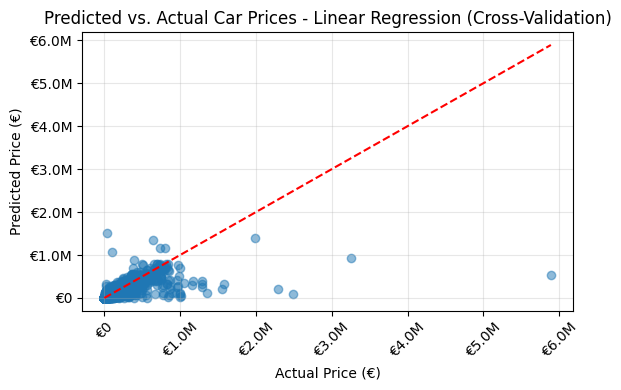

In [17]:
main()

-> mit K-Fold Cross Validation lässt sich ein robuster Score vorhersagen. Wir erstellen in dem Fall 10 Subsets und wählen in jedem Subset einen unterschiedlichen Teil zum Trainieren und zum Validieren. Am Ende bilden wir den Durchschnitt über die Metriken und erhalten den finalen Score. Der Score ist nicht mehr so abhängig von den vereinzelten Ausreißern, die den Score bei einem einfachen Training/Test Split sehr verzerren.